# Challenge
With just a text file of ordered pairs and a bunch of images of planes and dogs, what do you do??

This is challenge 2 of the HackMIT Puzzle and it was the hardest one imo. This notebook explores 2 approaches to the puzzle.

## Approach 1
Create a neural network with ResNet to classify plane pictures!

## Approach 2
Hash all plane pictures from the cifar10 dataset and compare hashes of the given plane images to classify plane pictures.

Regardless of which approach we take, we'll then place black squares for plane pictures in the positions given by the ordered pairs, forming an EPIC QR CODE that has our answer!

Let's get started!

In [12]:
%matplotlib inline
# imports
import matplotlib.pyplot as plt
from matplotlib.image import imread
from shutil import copyfile
from os import makedirs, listdir, remove, rename
from random import random, seed
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.optimizers import SGD, Adam
from numpy import asarray, save
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from PIL import Image
import numpy as np
from skimage import transform
import keras
from keras.applications import VGG19, ResNet50
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from tqdm import tqdm

# Approach 1 (Neural Nets)
Trying VGG19 and ResNet50

In [ ]:
# define the model
model = VGG19( weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()
for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs=model.inputs, outputs=output)

model.compile(optimizer='adam',loss= 'binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model2 = ResNet50(include_top = False, weights='imagenet', input_shape=(32,32,3))

model_2 = Sequential()
model_2.add(model2)
model_2.add(Flatten())
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(1,activation=('sigmoid'))) #This is the classification layer
model_2.summary()

adam=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model_2.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
#Load the data
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
batch_size = 64
# Change the name of the file to whatever you'd like, but I used `dhome`
train_iter = datagen.flow_from_directory(r'dhome/train/',
                                         class_mode='binary',
                                         batch_size = batch_size,
                                         classes = ['dog', 'plane'],
                                         target_size=(32,32))

test_datagen = ImageDataGenerator(rescale=1./255)

test_iter = test_datagen.flow_from_directory(r'dhome/test/',
                                        class_mode='binary',
                                        batch_size = 1,
                                        target_size=(32,32),
                                        classes = ['dog', 'plane'])


In [ ]:
# TRAIN
history = model_2.fit(train_iter,
                    steps_per_epoch=len(train_iter),
                    validation_data=test_iter,
                    validation_steps=len(test_iter),
                    epochs=15)

In [ ]:
_, acc = model_2.evaluate_generator(test_iter, steps=len(test_iter), verbose=0)
print('> %.3f' % (acc * 100.0))
model_2.save("Dropout_and_more_data")

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')

In [ ]:
folder = "./images/"

test_pic = "3959.png"
print(folder + test_pic)
img = Image.open(folder + test_pic)
px = np.asarray(img)
px = px.astype('float32')/255.0
px = np.expand_dims(px, axis=0)
plt.imshow(imread(folder + test_pic))
model_2.predict(px)

In [ ]:
# fig = plt.figure(num=None,figsize=(10,10), dpi=80)
biglist = [-1] * len(listdir(folder))
for idx, pic in enumerate(listdir(folder)):
  # print(int(pic[:pic.index(".png")]))
  np_image = imread(folder + pic)
  
  predict_image = np_image.astype('float32')/255.0
  predict_image = np.expand_dims(np_image, axis=0)
  index = int(pic[:pic.index(".png")])
  # print(f"AT {index}")
  biglist[index] = model_2.predict(predict_image)[0][0]
  # print(biglist)

print(biglist)
np.savetxt("predicted_labels", np.array(biglist))
predicted = np.array(biglist)
predicted

In [ ]:
with open('ass_latest.txt', 'r') as f:
  data = f.read().split('\n')

In [ ]:
fig = plt.figure(num=None, figsize=(69,69), dpi = 80, facecolor='w')
plt.axis('off')

for linenum, dataline in enumerate(data):
  if "," in dataline:
    nospace = dataline.replace(" ", "")
    a,b = int(nospace[1 :nospace.index(",")]), int(nospace[nospace.index(",") + 1:-1])
    if predicted[linenum] >= 0.5:
      ax = fig.add_subplot(69,69, a * 69 + b+1)
      ax.set_axis_off()
      plt.imshow(imread(f"./images/{linenum}.png"))

plt.show()

In [ ]:
fig = plt.figure(num=None, figsize=(69,69), dpi = 80, facecolor='w')
plt.axis('off')
count = 0
for linenum, dataline in enumerate(data):
  if "," in dataline:
    nospace = dataline.replace(" ", "")
    a,b = int(nospace[1 :nospace.index(",")]), int(nospace[nospace.index(",") + 1:-1])
    start += 1
    if predicted[linenum] >= 0.5:
      ax = fig.add_subplot(69,69, a * 69 + b+1)
      ax.set_axis_off()
      plt.imshow(imread(f"./black.png"))

plt.show()

# Approach 2 (Comparing Images)

In [5]:
checks = ["./cifar10pngs/train/airplane/", "./cifar10pngs/test/airplane/"]

src_dir = "./images/"
cifar = list()
for folder in checks:
    for pic in listdir(folder):
        img = list(Image.open(folder + pic).getdata())
        cifar.append(img)

In [6]:
dic = {}
for pic in listdir(src_dir):
    bob = list(Image.open(src_dir + pic).getdata())
    for image in cifar:
        if bob == image:
            dic[int(pic[:pic.index(".png")])] = 1

In [7]:
with open('ass_latest.txt', 'r') as f:
    data = f.read().split('\n')

100%|██████████| 10001/10001 [02:50<00:00, 58.61it/s]


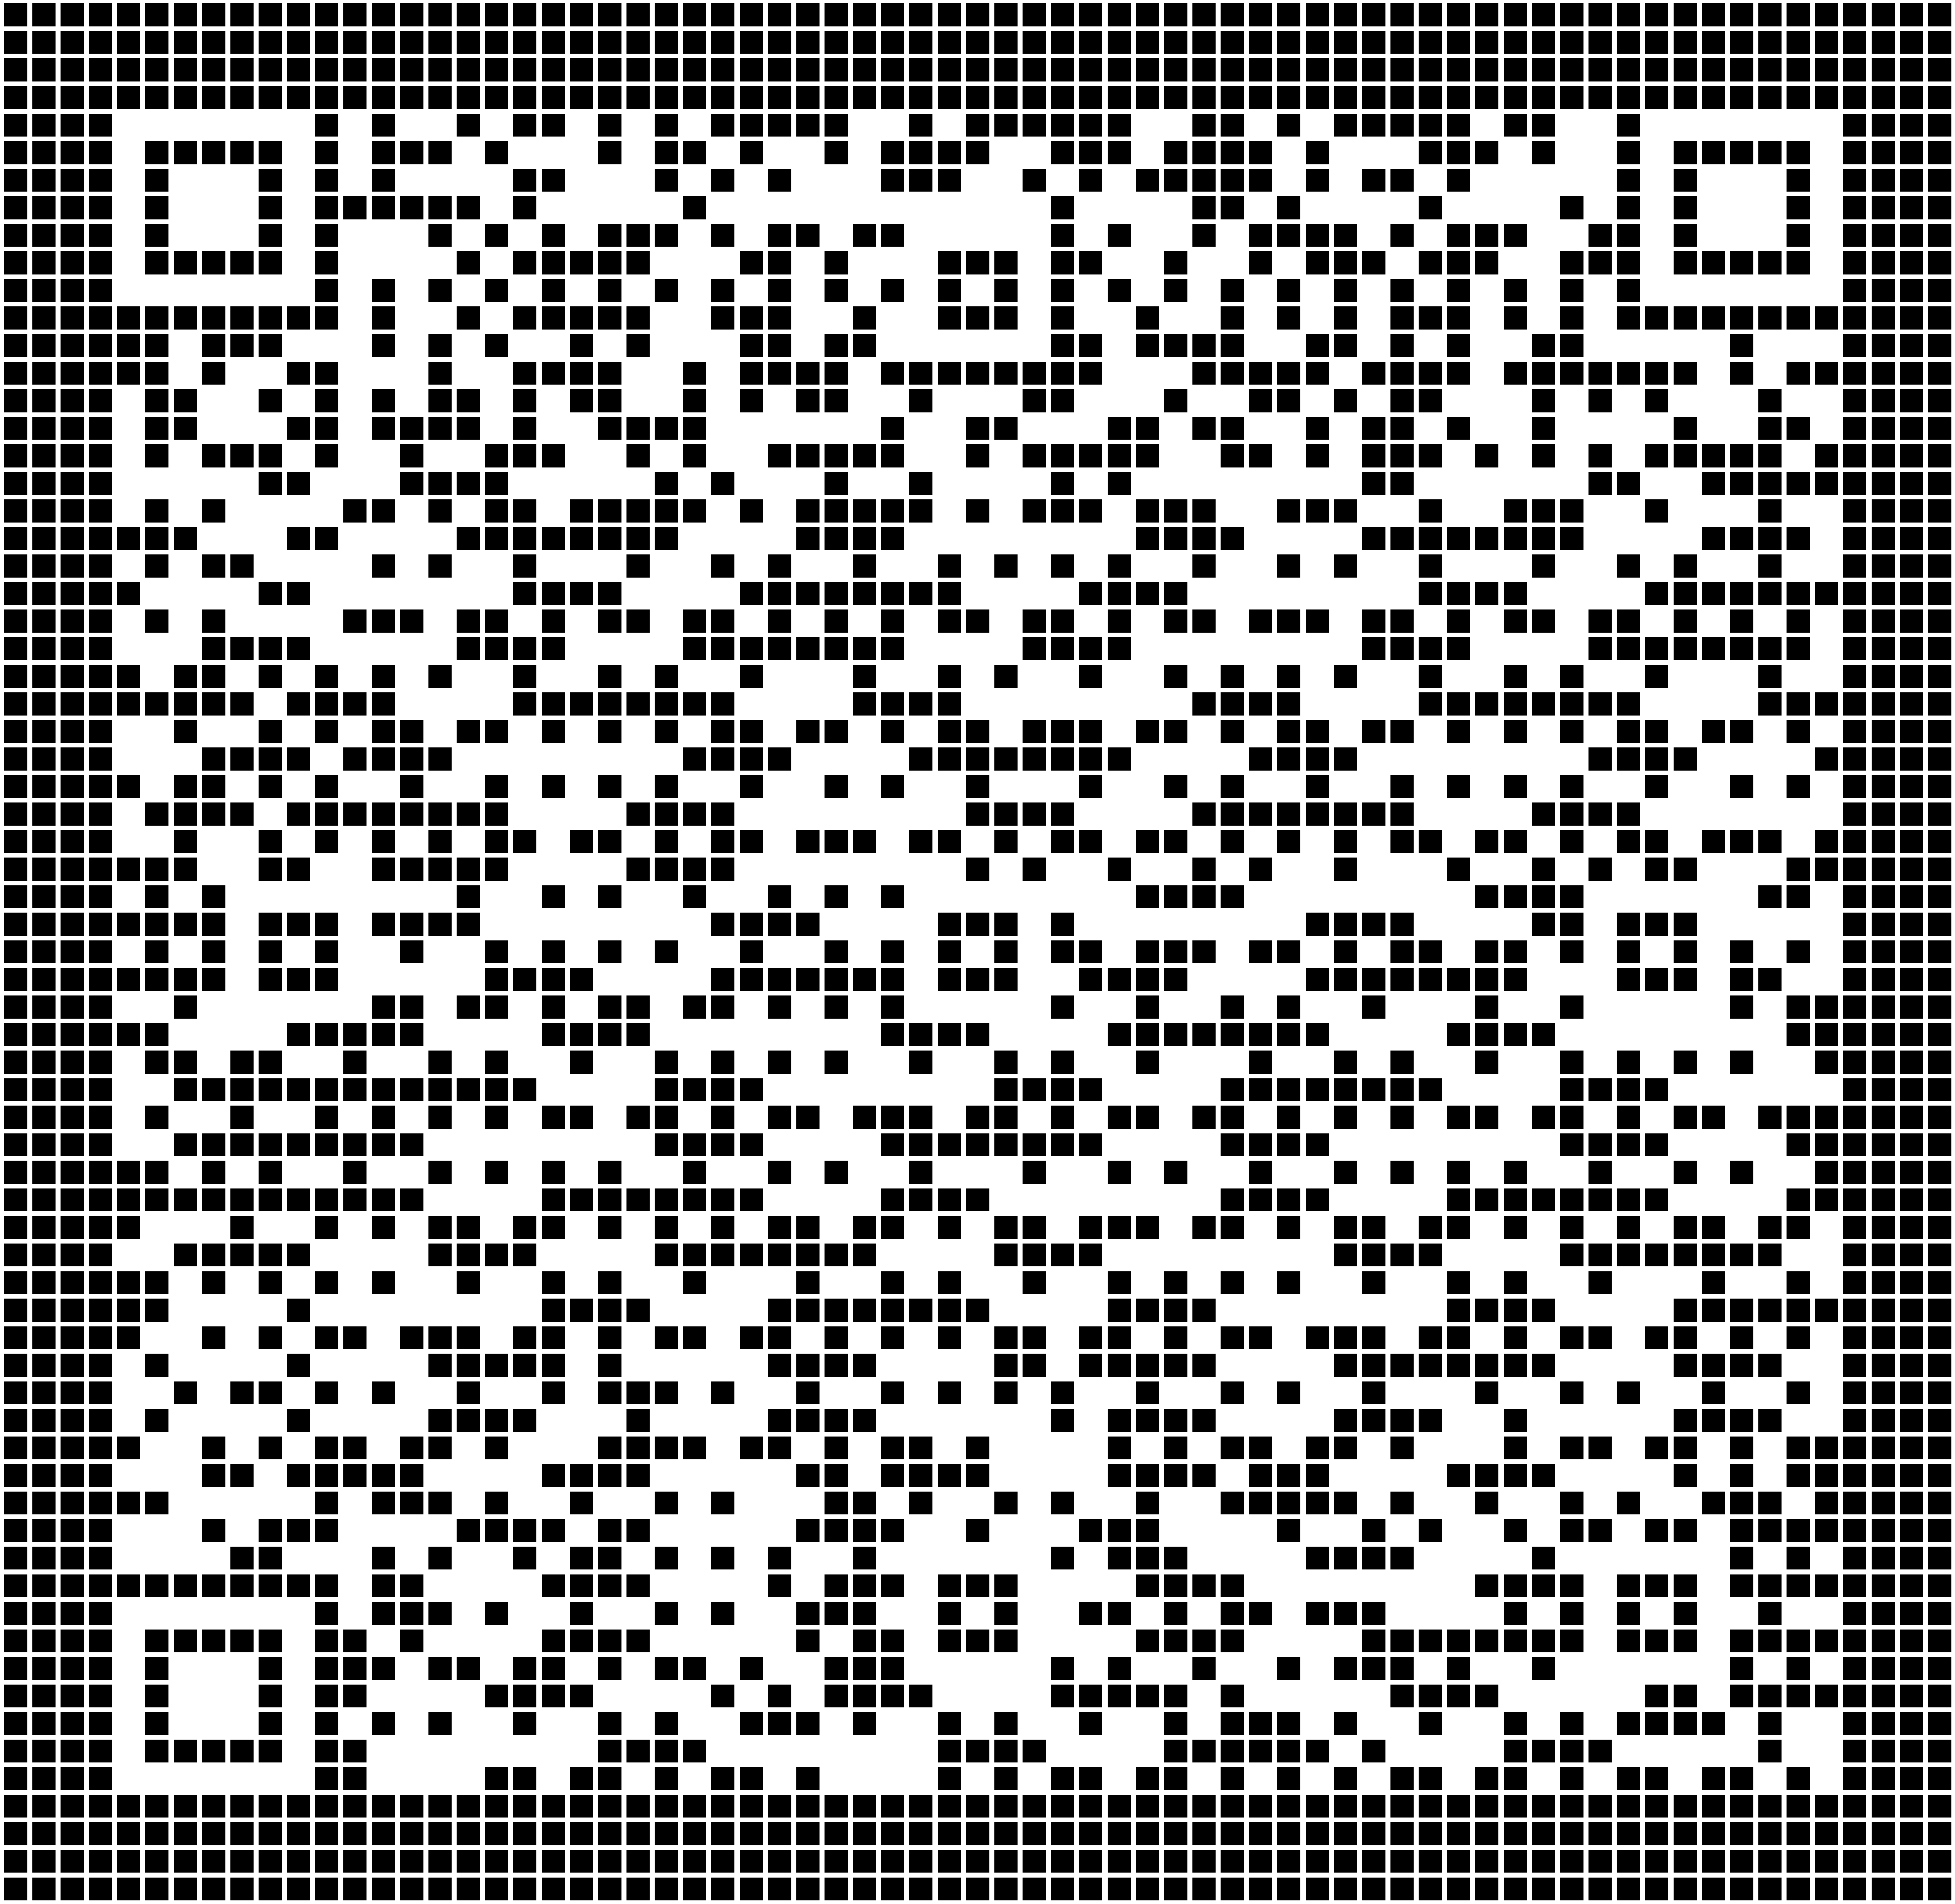

In [14]:
black = plt.imread("./black.png")
fig = plt.figure(num=None, figsize=(69,69), dpi = 80, facecolor='w')
plt.axis('off')

for linenum, dataline in tqdm(enumerate(data), total=len(data)):
  if "," in dataline:
    nospace = dataline.replace(" ", "")
    a,b = int(nospace[1 :nospace.index(",")]), int(nospace[nospace.index(",") + 1:-1])
    if linenum in dic:
      ax = fig.add_subplot(69,69, a * 69 + b+1)
      ax.set_axis_off()
      plt.imshow(black)

# Answer
fourth only throughout

!!!YAYYY!!